## importation des bibliothèques et création des données d'entrainement et de validation

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


import keras
from keras import optimizers, layers, applications
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.initializers import glorot_uniform
from keras.applications import VGG16
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
categories=[]

train_images= os.listdir('/content/drive/MyDrive/AutismDataset/train/')
for image_name in train_images:
  category= image_name.split('.')[0]
  if(category=='Autistic'):
    categories.append(str(1))
  else:
    categories.append(str(0))

train_df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})


In [ ]:
categories=[]

test_images= os.listdir('/content/drive/MyDrive/AutismDataset/test/')
for image_name in test_images:
  category= image_name.split('.')[0]
  if(category=='Autistic'):
    categories.append(str(1))
  else:
    categories.append(str(0))

test_df = pd.DataFrame({
    'filename': test_images,
    'category': categories
})

In [ ]:
print("train dataframe ", train_df.head(2))
print("test dataframe ", test_df.head(2))

train dataframe                  filename category
0  Non_Autistic.1246.jpg        0
1  Non_Autistic.1248.jpg        0
test dataframe             filename category
0  Autistic.100.jpg        1
1  Autistic.104.jpg        1


Autistic.894.jpg


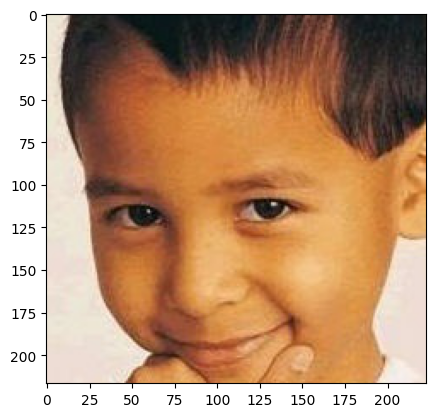

In [ ]:
sample = random.choice(train_images)
image = load_img("/content/drive/MyDrive/AutismDataset/train/"+sample)
print(sample)
plt.imshow(image)

In [ ]:
# the training and validation set
train_df, validate_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [ ]:
image_size = 224
input_shape = (image_size, image_size, 3)
batch_size = 20

# Data Augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', # to fill the new created pixels with the nearest values
    width_shift_range=0.1, # randomly shift the images vertically
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/MyDrive/AutismDataset/train/",
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2286 validated image filenames belonging to 2 classes.


In [ ]:
# Data augmentation for validation set
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/drive/MyDrive/AutismDataset/train/",
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 254 validated image filenames belonging to 2 classes.


## Transfer learning avec VGG16

In [ ]:
image_size = 224
input_shape = (image_size, image_size, 3)


epochs = 4
batch_size = 20

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output) #flatten the output to 1D
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
#Fit the Model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/4
114/114 [==============================] - 54s 471ms/step - loss: 0.6678 - accuracy: 0.6077 - val_loss: 0.5620 - val_accuracy: 0.7375
Epoch 2/4
114/114 [==============================] - 50s 435ms/step - loss: 0.5349 - accuracy: 0.7321 - val_loss: 0.4389 - val_accuracy: 0.7917
Epoch 3/4
114/114 [==============================] - 52s 454ms/step - loss: 0.4995 - accuracy: 0.7608 - val_loss: 0.5305 - val_accuracy: 0.7333
Epoch 4/4
114/114 [==============================] - 60s 523ms/step - loss: 0.4725 - accuracy: 0.7793 - val_loss: 0.4202 - val_accuracy: 0.8083


In [ ]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

<ipython-input-25-5bf9ded073bc>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)


Test: accuracy = 0.795833  ;  loss = 0.421205 


In [ ]:
model.save('my_model')
model.save('model.h5')

In [ ]:
# Data augmentation for test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    "/content/drive/MyDrive/AutismDataset/test/",
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False
)

Found 300 validated image filenames belonging to 2 classes.


In [ ]:
## Predictions
threshold = 0.5
nb_samples=test_df.shape[0]
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))
test_df['predictions'] = np.where(predict > threshold, 1,0)

15/15 [==============================] - 93s 7s/step


In [ ]:
#See the Predicted Result
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()

,index,filename,category,predictions
0,273,Non_Autistic.78.jpg,0,0
1,26,Autistic.132.jpg,1,1
2,170,Non_Autistic.118.jpg,0,0
3,239,Non_Autistic.45.jpg,0,0
4,113,Autistic.8.jpg,1,1


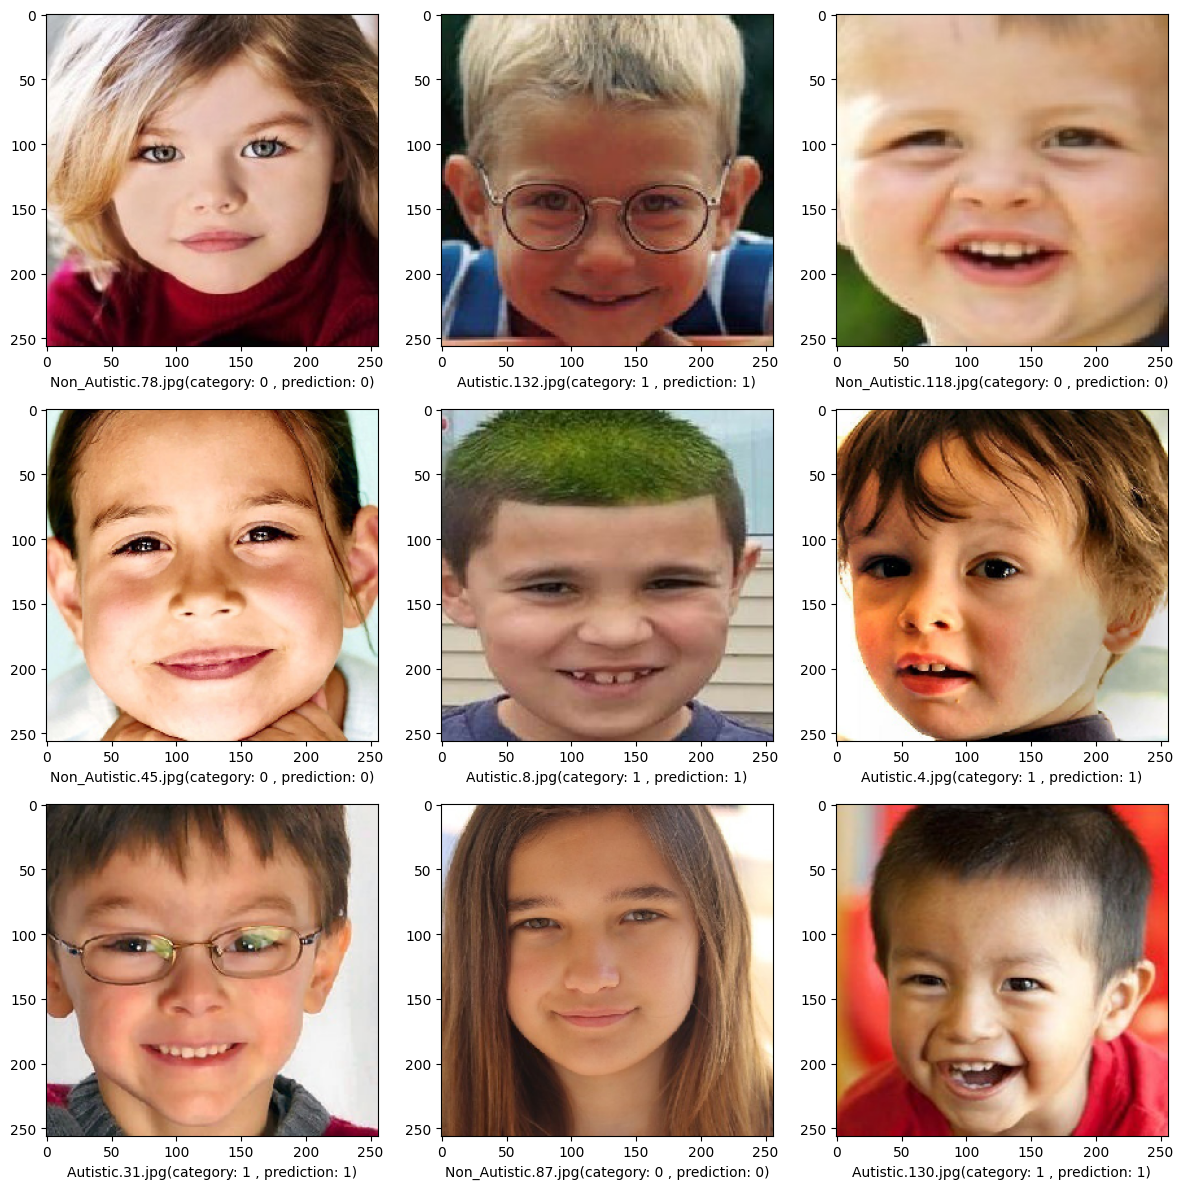

In [ ]:
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    predictions = row['predictions']
    img = load_img("/content/drive/MyDrive/AutismDataset/test/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "category: {} , ".format(category) + "prediction: {}".format(predictions) + ')')
plt.tight_layout()
plt.show()

## Augmenter l'accuracy

In [ ]:
from tensorflow.keras.models import load_model
model= load_model('/content/model.h5')



In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint('/content/mymodel{epoch}.h5', save_weights_only=False)


In [ ]:
#Fit the Model
model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[checkpoint_callback])

Epoch 1/5
114/114 [==============================] - 1252s 11s/step - loss: 0.4524 - accuracy: 0.7851 - val_loss: 0.4408 - val_accuracy: 0.7958
Epoch 2/5
114/114 [==============================] - 51s 441ms/step - loss: 0.4262 - accuracy: 0.8005 - val_loss: 0.4010 - val_accuracy: 0.8167
Epoch 3/5
114/114 [==============================] - 51s 443ms/step - loss: 0.4114 - accuracy: 0.8124 - val_loss: 0.3741 - val_accuracy: 0.8458
Epoch 4/5
114/114 [==============================] - 52s 452ms/step - loss: 0.3820 - accuracy: 0.8283 - val_loss: 0.6227 - val_accuracy: 0.7375
Epoch 5/5
114/114 [==============================] - 52s 450ms/step - loss: 0.3693 - accuracy: 0.8305 - val_loss: 0.4240 - val_accuracy: 0.8042


In [ ]:
#Fit the Model
model.fit(
    train_generator,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[checkpoint_callback])

Epoch 1/2
114/114 [==============================] - 57s 495ms/step - loss: 0.2893 - accuracy: 0.8822 - val_loss: 0.4136 - val_accuracy: 0.8375
Epoch 2/2
114/114 [==============================] - 52s 450ms/step - loss: 0.2732 - accuracy: 0.8844 - val_loss: 0.3496 - val_accuracy: 0.8375


In [ ]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

<ipython-input-19-5bf9ded073bc>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)


Test: accuracy = 0.837500  ;  loss = 0.347079 


In [ ]:
import tensorflow
converter= tensorflow.lite.TFLiteConverter.from_keras_model(model)
tflite_model= converter.convert()

with open('model0.tflite', 'wb') as f:
  f.write(tflite_model)